In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import HTC
import time
from scipy import signal
import matplotlib.colors as colors

In [3]:
# Load connectome and normalize it
W=np.loadtxt("../Data/connectivity_matrix/weights.txt")
W_normalized=W/W.sum(axis=1)[:,None]
W_not_normalized=W

In [4]:
# Create brain object and set its parameters
brain_normalized=HTC.Brain(W_normalized)
brain_not_normalized=HTC.Brain(W_not_normalized)

n_neurons=brain_normalized.n_neurons
brain_normalized.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2, tc=0.15)
brain_not_normalized.set_netowrk_parameters(r1=2/n_neurons, r2=(2/n_neurons)**0.2, tc=0.15)

In [5]:
active_frac=0.1 #Initial fraction of active neurons
n_runs=50 #Parallel runs
tmin=0.01 #Min tc
tmax=0.3 #Max tc
delta_tc=0.01 #Variation of tc
dt=0.1 #Time step
n_timesteps=600 #Total number of timesteps
s_step=10 #Campute s1 s2 every s_step (to speed up computing time)
compute_s1_s2=False 
compute_s_distrib=False
compute_fc=True

In [6]:
%%time
output=brain_normalized.simulation(active_frac=active_frac, n_runs=n_runs,
                      tmin=tmin, tmax=tmax, delta_tc=delta_tc,
                      dt=dt, n_timesteps=n_timesteps,
                      compute_s1_s2=compute_s1_s2, s_step=s_step,
                      compute_s_distrib=compute_s_distrib, tc_distrib=0.15,
                      compute_fc=compute_fc)

output_not_normalized=brain_not_normalized.simulation(active_frac=active_frac, n_runs=n_runs,
                      tmin=tmin, tmax=tmax, delta_tc=delta_tc,
                      dt=dt, n_timesteps=n_timesteps,
                      compute_s1_s2=compute_s1_s2, s_step=s_step,
                      compute_s_distrib=compute_s_distrib, tc_distrib=0.15,
                      compute_fc=compute_fc)

CPU times: user 23.1 s, sys: 537 ms, total: 23.7 s
Wall time: 23.7 s


In [7]:
tc=output['tc']
a=output['activity']
sigma_a=output['sigma_activity']
fc=output['fc']

tc_not_normalized=output_not_normalized['tc']
a_not_normalized=output_not_normalized['activity']
sigma_a_not_normalized=output_not_normalized['sigma_activity']
fc_not_normalized=output_not_normalized['fc']

In [8]:
# Load data from specific subject
# Choose to read both blocks or not
def fmri_signal(subject=1, all_blocks=False):
    if all_blocks==True:
        a=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block1.txt")
        b=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block2.txt")
        return np.concatenate((a,b))
    elif all_blocks==False:
        a=np.loadtxt("../Data/fMRI/subj"+str(subject)+"_block1.txt")
        return a

# Getting ready for ordering of data using Hagmann way
labels_ponce=np.loadtxt('../Data/fMRI/ROIs_Labels.txt',dtype=str)
labels_hagmann=np.loadtxt("../Data/connectivity_matrix/centres.txt", dtype=str, usecols=0)
dic_ponce={v:i for i,v in enumerate(labels_ponce)}
new_order_ponce=[dic_ponce[i] for i in labels_hagmann]

    
signals=np.zeros((24,600,66))
for i in range(24):
    signals[i]=fmri_signal(i+1, all_blocks=True)
    
new_signals=np.zeros_like(signals)
for i in range(66):
    new_signals[:,:,i]=signals[:,:,new_order_ponce[i]]

    
#Compute FC for all subjects (Hagmann order)
correlations=np.zeros((24,66,66), dtype=np.float64)
for subj in range(24):
    correlations[subj]=np.corrcoef(new_signals[subj], rowvar=False)

#Take the mean of all 24 FC matrix
corr=np.mean(correlations, axis=0)

In [9]:
# Indexes of FC to be put to 0
range_zeroes= [67*i for i in range(66)]

corr_fmri=corr
norm_tc=fc
norm_0=fc
not_nor_fc=fc_not_normalized

for i in range_zeroes:
    corr_fmri.flat[i]=0
    for j in range(len(tc)):
        norm_tc[j].flat[i]=0
        norm_0[j].flat[i]=0
        not_nor_fc[j].flat[i]=0


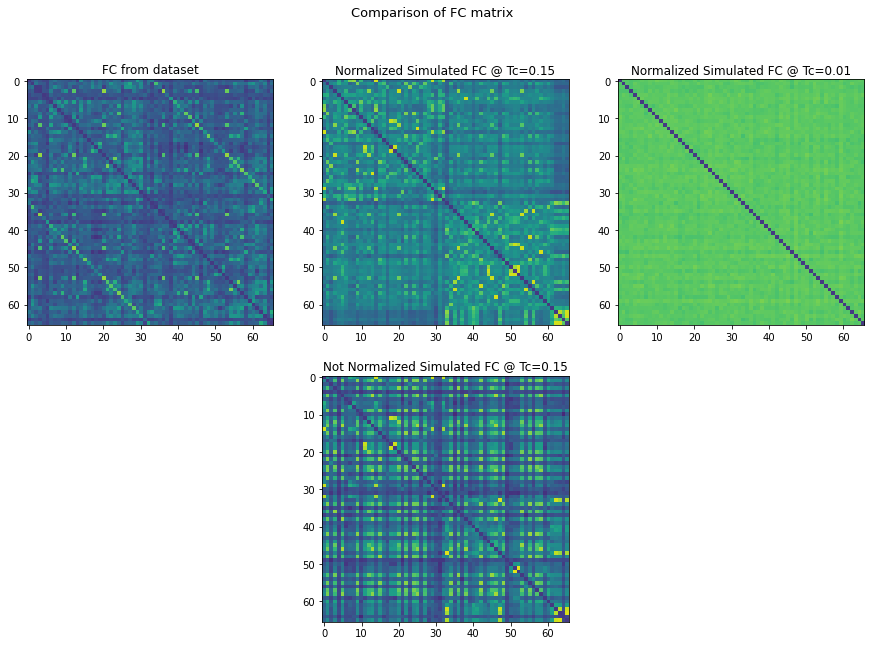

In [10]:
plt.figure(figsize=(15,10))
plt.subplot(2,3,1)


plt.imshow(corr_fmri,norm=colors.Normalize(vmin=-0.2, vmax=1))
plt.title('FC from dataset')

plt.subplot(2,3,2)
plt.imshow(norm_tc[14],norm=colors.Normalize(vmin=-0.2, vmax=1))
plt.title('Normalized Simulated FC @ Tc=%.2f'%tc[14])

plt.subplot(2,3,3)
plt.imshow(norm_0[0],norm=colors.Normalize(vmin=-0.2, vmax=1))
plt.title('Normalized Simulated FC @ Tc=%.2f'%tc[0])

plt.suptitle('Comparison of FC matrix\n', size=13)

plt.subplot(2,3,5)
plt.imshow(not_nor_fc[14],norm=colors.Normalize(vmin=-0.2, vmax=1))
plt.title('Not Normalized Simulated FC @ Tc=%.2f'%tc[14])

plt.show()

In [11]:
#Compute rho for all matrices af in Fig 2(a) Rocha
# Remove diagonal elements (they are all 1)
rho=np.zeros_like(tc)
rho_not_normalized=np.zeros_like(tc)


for i in range(len(tc)):
    rho[i]=np.corrcoef(corr_fmri.flatten(), norm_tc[i].flatten())[1,0]
        #np.delete(fc[i].flatten(),[67*i for i in range(66)]) ,
        #np.delete(corr.flatten(),[67*i for i in range(66)]))[1,0]
    
    rho_not_normalized[i]=np.corrcoef(corr_fmri.flatten(), not_nor_fc[i].flatten())[1,0]
        #np.delete(fc_not_normalized[i].flatten(),[67*i for i in range(66)]) ,
        #np.delete(corr.flatten(),[67*i for i in range(66)]))[1,0]

In [12]:
nbins=50

chi_norm=np.zeros((len(tc)))
chi_nnorm=np.zeros((len(tc)))

h_fmri,_=np.histogram(corr_fmri, bins=nbins)
h_fmri=h_fmri/h_fmri.sum()


for i in range(len(tc)):
    h_norm,_=np.histogram(norm_tc[i], bins=nbins)
    h_nnorm,_=np.histogram(not_nor_fc[i], bins=nbins)

    h_norm=h_norm/h_norm.sum()
    h_nnorm=h_nnorm/h_nnorm.sum()
    chi_norm[i]=np.sqrt(np.nansum((h_fmri-h_norm)**2/(h_fmri+h_norm)))
    chi_nnorm[i]=np.sqrt(np.nansum((h_fmri-h_nnorm)**2/(h_fmri+h_nnorm)))


/tmp/ipykernel_26550/896484163.py:16: RuntimeWarning: invalid value encountered in true_divide
  chi_norm[i]=np.sqrt(np.nansum((h_fmri-h_norm)**2/(h_fmri+h_norm)))
/tmp/ipykernel_26550/896484163.py:17: RuntimeWarning: invalid value encountered in true_divide
  chi_nnorm[i]=np.sqrt(np.nansum((h_fmri-h_nnorm)**2/(h_fmri+h_nnorm)))


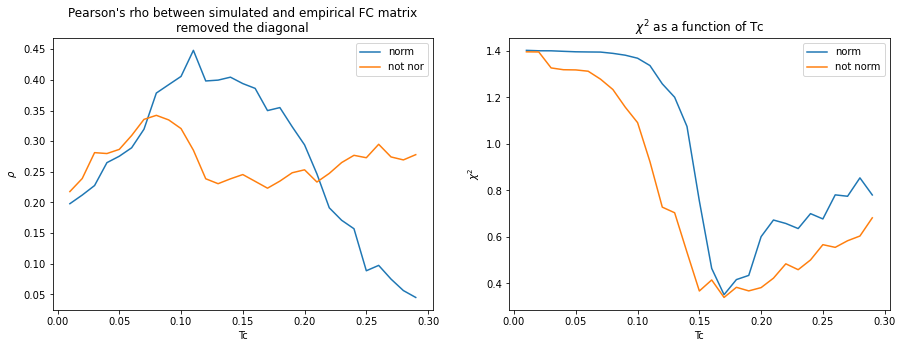

In [13]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(tc,rho, label='norm')
plt.plot(tc,rho_not_normalized,label='not nor')
plt.title("Pearson's rho between simulated and empirical FC matrix\nremoved the diagonal")
plt.xlabel('Tc')
plt.ylabel(r'$\rho$')
plt.legend()

plt.subplot(1,2,2)
plt.plot(tc,chi_norm, label='norm')
plt.plot(tc,chi_nnorm, label='not norm')

plt.title(r'$\chi^2$ as a function of Tc')
plt.xlabel('Tc')
plt.ylabel(r'$\chi^2$')
plt.legend()
plt.show()